# Skin Cancer Model

## Angelos Nikolas

### The dataset is available at: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

### Importing libraries reading data and setting their size

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

skin_data = pd.read_csv('HAM10000_metadata.csv')

# Setting size of the images
SIZE=32

### Converting classes to numeric values and printing the corresponding classes

In [12]:
# Converting classes names to numeric values
le = LabelEncoder()
le.fit(skin_data['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


### Creation of new column of the correspodning numeric values assig

In [13]:
# Transforming dx numeric values to a new column called classes
skin_data['classes'] = le.transform(skin_data["dx"]) 
print(skin_data.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  classes  
1617             face        4  
8128  lower extremity        5  
2168             back        4  
1090            trunk        2  
7754          abdomen        5  
8071            trunk        5  
7423  upper extremity        5  
8984  lower extremit

For each class a numerical value is assigned for example nv = 5.

### Distribution of cell types graph and sex allocation

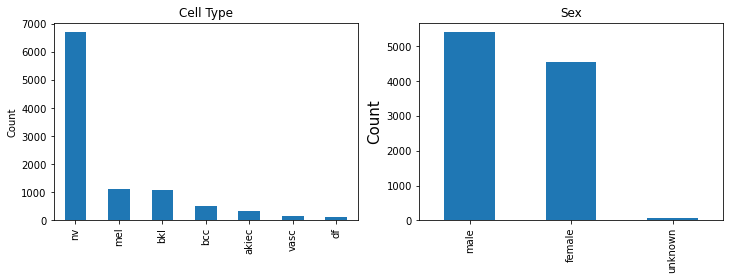

In [14]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_data['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_data['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');



From the cell type graph it is noticable that the nv classe dominates the observations. The sex distribution is satisfactory balanced.

### Distribution of the localization of the observations

Text(0.5, 1.0, 'Localization')

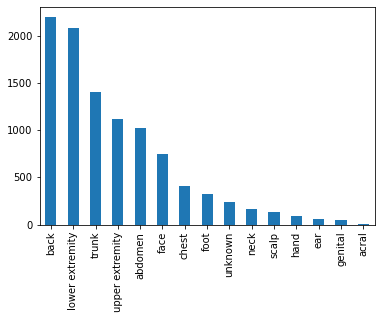

In [15]:
ax3 = fig.add_subplot(223)
skin_data['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')




Most observations are made on the back and lower extremity.

### Distribution of the ages in the sample group

C:\Users\Aggelos\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Age')

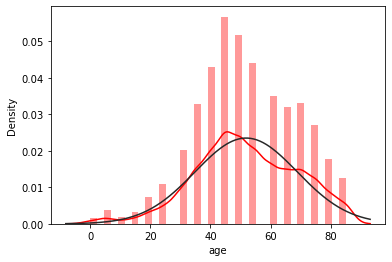

In [16]:
ax4 = fig.add_subplot(224)
sample_age = skin_data[pd.notnull(skin_data['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

The average age of the patients is approximatly 44.

### Checking classes distribution of the data and perfoma balancing

In [20]:
# Checking the distribution of the variables
from sklearn.utils import resample
print(skin_data['classes'].value_counts())

# Balancing the data randomly sampling 500 images of each class.
df_0 = skin_data[skin_data['classes'] == 0]
df_1 = skin_data[skin_data['classes'] == 1]
df_2 = skin_data[skin_data['classes'] == 2]
df_3 = skin_data[skin_data['classes'] == 3]
df_4 = skin_data[skin_data['classes'] == 4]
df_5 = skin_data[skin_data['classes'] == 5]
df_6 = skin_data[skin_data['classes'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

# Merging the samples into a new data frame
skin_data_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: classes, dtype: int64


The data before balancing.

### Checking the distribution of the balanced data

In [21]:
#Checking the variable distribution on the balanced dataframe
print(skin_data_balanced['classes'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: classes, dtype: int64


In [10]:
The data after balancing.

SyntaxError: invalid syntax (Temp/ipykernel_18508/1070845376.py, line 1)

### Reading the Images and adding them as new column based on the image ID

In [22]:
# Reading the images based on the image ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('', '*', '*.jpg'))}

#Define the path and add as a new column
skin_data_balanced['path'] = skin_data['image_id'].map(image_path.get)
#Use the path to read images.
skin_data_balanced['image'] = skin_data_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))




The balanced data frame now includes the path and the image itself.

### Data prepare for modelling

In [23]:
#Convert dataframe column of images into array
X = np.asarray(skin_data_balanced['image'].tolist())
X = X/255.  # Scale values to ranges of 0-1. 
Y=skin_data_balanced['classes']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical to solve multiclassificartion problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

Creation of X and Y variable for training and testing. The pixels are normalized to values ranging from 0-1.

### Defining the model

In [24]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          7

The first sequence of the model has 256 Convolutional filters the next 128 and the last 64. The density is set to 32 and the output layer is set to 7 nodes using softmax for multiclass classification. For loss function categorical crossentropy with Adam optimizer is used.

### Initiating training and printing accuracy

In [25]:
# Training 
# This may take some time

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

#Model accuracy 
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
165/165 - 13s - loss: 1.9077 - acc: 0.1950 - val_loss: 1.9884 - val_acc: 0.1909
Epoch 2/50
165/165 - 12s - loss: 1.7864 - acc: 0.2579 - val_loss: 1.7720 - val_acc: 0.3097
Epoch 3/50
165/165 - 12s - loss: 1.6597 - acc: 0.3219 - val_loss: 1.5616 - val_acc: 0.3371
Epoch 4/50
165/165 - 12s - loss: 1.5157 - acc: 0.3806 - val_loss: 1.5080 - val_acc: 0.3943
Epoch 5/50
165/165 - 12s - loss: 1.4507 - acc: 0.4316 - val_loss: 1.3901 - val_acc: 0.4446
Epoch 6/50
165/165 - 12s - loss: 1.3907 - acc: 0.4590 - val_loss: 1.3598 - val_acc: 0.4686
Epoch 7/50
165/165 - 12s - loss: 1.3173 - acc: 0.4888 - val_loss: 1.3760 - val_acc: 0.4251
Epoch 8/50
165/165 - 12s - loss: 1.3152 - acc: 0.4750 - val_loss: 1.3297 - val_acc: 0.4697
Epoch 9/50
165/165 - 12s - loss: 1.2727 - acc: 0.4941 - val_loss: 1.2728 - val_acc: 0.4674
Epoch 10/50
165/165 - 13s - loss: 1.2342 - acc: 0.5116 - val_loss: 1.1804 - val_acc: 0.5794
Epoch 11/50
165/165 - 13s - loss: 1.2355 - acc: 0.5154 - val_loss: 1.3011 - val_acc: 0.45

The size of images checked are 16 per batch and 50 epochs for each batch.
Then the model is fitted and the test accuracy is calculated and printed.

### Plotting Validation accuracy and epoch loss

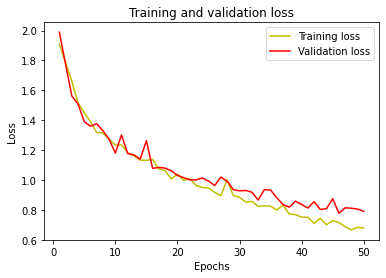

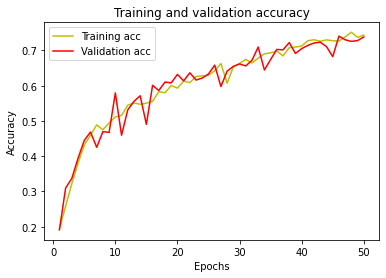

In [26]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The grapsh detailing the loss and accuracy in each epoch. Highly suggesting that with 20-30 additional epochs the accuracy could peak at 80%.

### Prediction and Confusion Matrix

<AxesSubplot:>

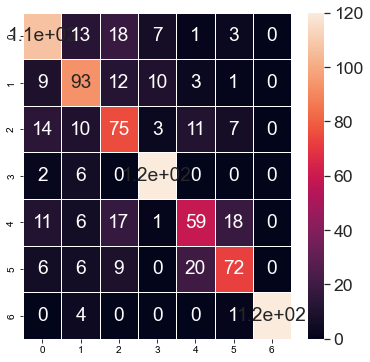

In [27]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

The confusion matrix show that classes 0, 3 and 6 performed really well.